<a href="https://colab.research.google.com/github/aidanjmaldonado/penny-stock-lstm/blob/main/penny_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.callbacks import EarlyStopping
import sqlite3
import requests
import sys
import pytz








# Create database

In [4]:
# Download database from github repository
historical_url = "https://raw.githubusercontent.com/CSE-115-UCSC/penny-stock-lstm/main/historicaldata.db"
scrape_request = requests.get(historical_url)

try:
  # Contingent on request status
  scrape_request = requests.get(historical_url)
  scrape_request.raise_for_status()

  # Create local database from pull, name 'historicaldata.db'
  with open("historical.db", "wb") as db_file:
    db_file.write(scrape_request.content)

  print("Request to download database succeeded")


except:
  # Report failed request status
  sys.stderr.write("Request to download database failed")

Request to download database succeeded


In [4]:
# Connect to SQlite database
try:
    db = 'historical.db'
    sqliteConnection = sqlite3.connect(db)
    cursor = sqliteConnection.cursor()
    print(f'SQlite connected with {db}')

except:
    sys.stderr.write("Failed to connect to database")

SQlite connected with historical.db


In [26]:
# Query {ticker(s)} from Database
try:
    query = f"SELECT * FROM all_historical WHERE ticker != 'GSAT';"
    cursor.execute(query)
    if cursor.fetchone() is None:
        raise Exception("No results")

    print(f"Success querying all historical")
    # Turn SQlite Database into Pandas Dataframe
    data = pd.read_sql_query(query, sqliteConnection)

except:
    sys.stderr.write(f"Failed to select all historical")

Success querying all historical


In [27]:
# Using the column 'time' (millisecond) add a new column 'dates' with datetime
dates = pd.to_datetime(data['time'], unit='ms')
tickers = data['ticker']
dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
dates = dates.dt.tz_localize(None)

# Train on all historical stock data, sequenced

In [28]:
# Select features to use
features = data[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

def create_sequences(data, sequence_length, prediction_length):
    xs, ys = [], []
    index = 0
    count = 0
    while index < len(data) - sequence_length - prediction_length + 1:
        # Check if sequence is within a single day
        if dates[index].date() == dates[index + sequence_length].date() and tickers[index] == tickers[index + sequence_length]:
            # If day == 2024-05-31, print
            # if dates[index] == "2024-05-31":
            # print("We got a sequence from", dates[index], "to", dates[index + sequence_length], "sequence-length is", (index + sequence_length) -index, tickers[index], tickers[index + sequence_length])
            xs.append(data[index:index + sequence_length])
            ys.append(data[index + sequence_length:index + sequence_length + prediction_length, 3])
            index += sequence_length
            count += 1
        else:  # Move index to the start of the next day
            newindex = index
            while dates[newindex].date() == dates[newindex + 1].date():
                newindex += 1
            newindex += 1
            index = newindex
    print("Valid days:", count)
    return np.array(xs), np.array(ys)

# One day sequence lenght
sequence_length = 78
prediction_length = 78
x, y = create_sequences(scaled_features, sequence_length, prediction_length)

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split data into train and test sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, x_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(prediction_length))

model.compile(optimizer='adam', loss='mse')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
model.evaluate(x_test, y_test)

Valid days: 290
x_train shape: (232, 78, 6)
y_train shape: (232, 78)
x_test shape: (58, 78, 6)
y_test shape: (58, 78)
Epoch 1/100
7/7 [==============================] - 5s 231ms/step - loss: 9.9508e-07 - val_loss: 1.9316e-07
Epoch 2/100
7/7 [==============================] - 1s 75ms/step - loss: 4.6868e-07 - val_loss: 2.9464e-07
Epoch 3/100
7/7 [==============================] - 1s 78ms/step - loss: 3.7481e-07 - val_loss: 1.5429e-07
Epoch 4/100
7/7 [==============================] - 1s 78ms/step - loss: 3.2593e-07 - val_loss: 1.3581e-07
Epoch 5/100
7/7 [==============================] - 1s 112ms/step - loss: 3.1144e-07 - val_loss: 1.6861e-07
Epoch 6/100
7/7 [==============================] - 1s 130ms/step - loss: 3.0386e-07 - val_loss: 1.3514e-07
Epoch 7/100
7/7 [==============================] - 1s 129ms/step - loss: 2.9499e-07 - val_loss: 1.3012e-07
Epoch 8/100
7/7 [==============================] - 1s 130ms/step - loss: 3.0061e-07 - val_loss: 2.6020e-07
Epoch 9/100
7/7 [============

0.016174405813217163

# Prediction on unseen 'Real-Time' stock


In [29]:
# Create Prediction Stock dataset

try:
  query = f"SELECT * FROM all_historical WHERE ticker = 'GSAT';" # *NOTE* Cannot run predictions on EVGN_Predict rn because it has 0 valid days, using GSAT
  cursor.execute(query)
  if cursor.fetchone() is None:
    raise Exception("No results")
  print(f"Success querying EVGN_Predict")
except:
  sys.stderr.write(f"Failed to select EVGN_Predict")

# Turn SQlite Database into Pandas Dataframe
predict_data_whole = pd.read_sql_query(query, sqliteConnection)

# Split into known vs unknown, where unknown is the last 78 entries
split_index_whole = len(predict_data_whole) - 78
known_data_whole = predict_data_whole.iloc[:-78]
unknown_data_whole = predict_data_whole.iloc[-78:]

# Features
known_features = known_data_whole[['volume', 'volume_weighted_average', 'open', 'close', 'high', 'low']].values

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_known_features = scaler.fit_transform(known_features)



Success querying EVGN_Predict


In [30]:
# Create dates column from miliseconds
dates = pd.to_datetime(known_data_whole['time'], unit='ms')
tickers = known_data_whole['ticker']
dates = dates.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
dates = dates.dt.tz_localize(None)

In [31]:
# Create Prediction Sequences
sequence_length = 78
prediction_length = 78
x_predict, y_predict = create_sequences(scaled_known_features, sequence_length, prediction_length)

Valid days: 4


In [32]:
# Predict with model
predicted_stock_sequence = model.predict(x_predict)

# Evaluate the model
model.evaluate(x_predict, y_predict)

1/1 [==============================] - 0s 36ms/step - loss: 0.3438


0.34380266070365906

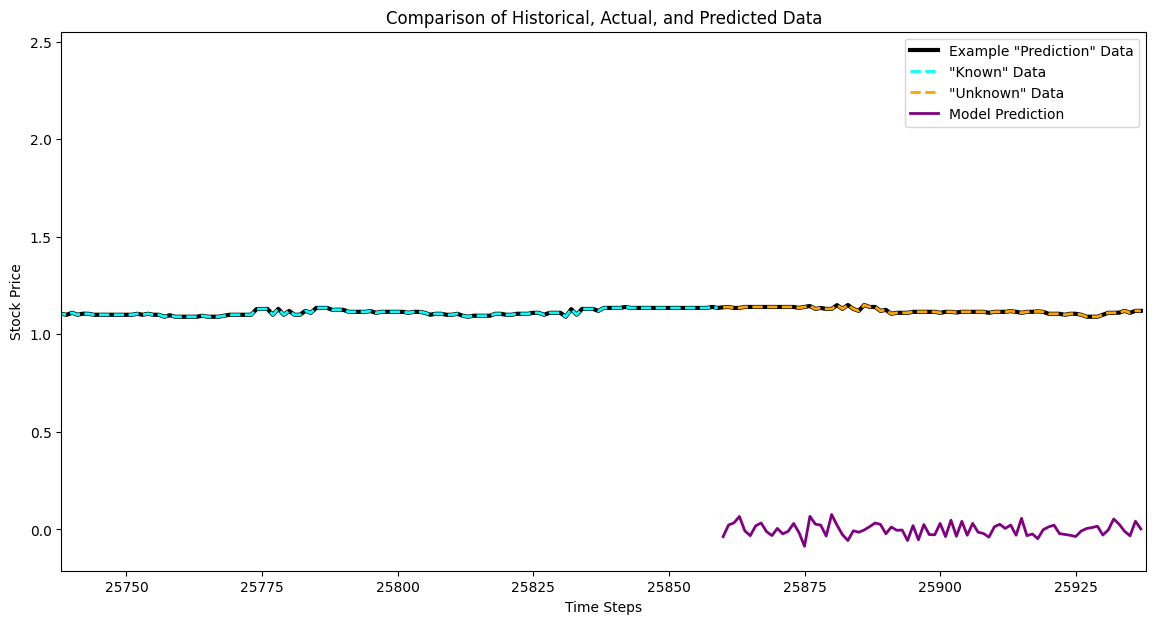

In [33]:
# Plot results
import matplotlib.pyplot as plt

# Create the combined index for plotting
combined_index = np.arange(len(predict_data_whole))

# Create
plt.figure(figsize=(14, 7))

# Plot
plt.plot(combined_index, predict_data_whole['close'], label='Example "Prediction" Data', color='black', linewidth=3.0)
plt.plot(combined_index[:split_index_whole], known_data_whole['close'], label='"Known" Data', color='cyan', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], unknown_data_whole['close'], label='"Unknown" Data', color='orange', linewidth=2.0, linestyle="--")
plt.plot(combined_index[split_index_whole:], predicted_stock_sequence[1], label='Model Prediction', color='purple', linewidth=2.0, linestyle="-")

# Format
plt.title('Comparison of Historical, Actual, and Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()

# Adjust y-axis limits based on the data range
# plt.ylim(predict_data_whole.iloc[-200:]['close'].min() - 0.2, predict_data_whole.iloc[-200:]['close'].max() + 0.2)
plt.xlim(len(predict_data_whole) - 200, len(predict_data_whole))  # Crop view to just the very end

# Set y-tick locations with a step of 0.05
# yticks = np.arange(min(predict_data_whole['close']) // 0.05 * 0.05, (max(predict_data_whole['close']) // 0.05 + 1) * 0.05, 0.05)
# plt.yticks(yticks)

plt.show()
